# CREATE A COPY FIRST!

# **Question 1: Fine-Tune EfficientNetV2-Medium for Bone Fracture Classification**

##### This dataset contains **X-ray images** of various types of bone fractures, categorized into **12 classes**.

##### Complete the tasks below to fine-tune a **pretrained EfficientNetV2-Medium** model on this dataset to classify bone fractures.

In [ ]:
# # Please uncomment this out when you are running this lab on google colab!
import os

# # Set KaggleHub cache to a directory inside /content/
os.environ["KAGGLEHUB_CACHE"] = "/content/data"

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("shyamgupta196/bone-fracture-split-classification")

print("Path to dataset files:", path)

100%|██████████| 153M/153M [00:02<00:00, 53.6MB/s]

Extracting files...


Path to dataset files: /content/data/datasets/shyamgupta196/bone-fracture-split-classification/versions/1


In [ ]:
class_to_idx = {
    "Avulsion fracture": 0,
    "Comminuted fracture": 1,
    "Compression-Crush fracture": 2,
    "Fracture Dislocation": 3,
    "Greenstick fracture": 4,
    "Hairline Fracture": 5,
    "Impacted fracture": 6,
    "Intra-articular fracture": 7,
    "Longitudinal fracture": 8,
    "Oblique fracture": 9,
    "Pathological fracture": 10,
    "Spiral Fracture": 11
}

# TASK 1: Define the Dataset Class & Dataloader

### Note: You can build a custom dataset class or use any torch built-in dataset classes (e.g. TensorDataset, ImageFolder,...)

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms,datasets
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [ ]:
## TO DO...using buikt in dataset classes to load data:
#defining transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert('RGBA') if x.mode == 'P' else x),  # Convert palette to RGBA
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert('RGBA') if x.mode == 'P' else x),  # Convert palette to RGBA
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # These random ahh values were found using ImageNet dataset, https://paperswithcode.com/dataset/imagenet
                          std=[0.229, 0.224, 0.225])
])

# Define dataset paths
train_path = f"{path}/train"
test_path = f"{path}/test"

# Create dataset objects using ImageFolder
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=test_transform)


# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Check a batch of images
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}, Labels: {labels}")


Batch shape: torch.Size([32, 3, 224, 224]), Labels: tensor([11,  5,  7,  3,  4,  0, 11,  8,  3, 10,  7,  4,  1,  8,  0,  8,  4,  1,
        11,  1, 10,  1, 11,  2,  2,  0, 11,  0,  3,  4,  5,  2])


## TASK 2: Display some images from the dataset

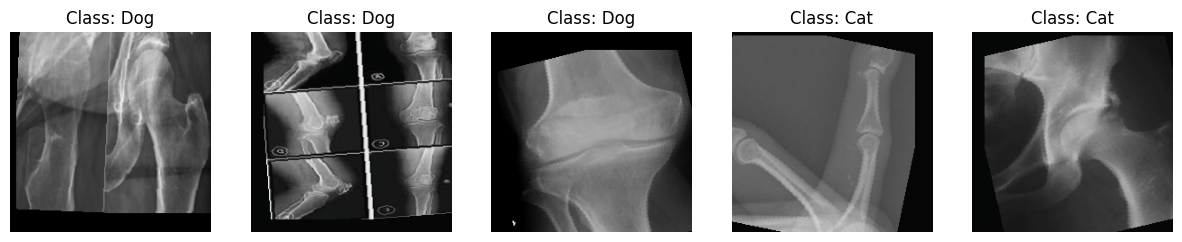

In [ ]:
# TO DO
import matplotlib.pyplot as plt
import numpy as np

# Define mean & std for denormalization (EfficientNet Preprocessing)
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Display 5 images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

imgs_indices = [270,233,110,89,15]

for i in range(5):
    img, label = train_dataset[imgs_indices[i]]  # Load image & label

    # Convert tensor to numpy for visualization
    img_np = img.numpy().transpose(1, 2, 0)  # (C, H, W) → (H, W, C)

    # Denormalize the image
    img_np = std * img_np + mean
    img_np = np.clip(img_np, 0, 1)

    # Show image
    axes[i].imshow(img_np)
    axes[i].set_title(f'Class: {"Cat" if label == 0 else "Dog"}')
    axes[i].axis('off')

plt.show()

# TASK 3: Define the Model

### You should finetune EfficientNetV2 Medium. Can be imported as follows:

from torchvision.models import efficientnet_v2_m

In [ ]:
# TO DO
from torchvision import models

# Load pretrained EfficientNet-B0
model = models.efficientnet_v2_m(pretrained=True)

# Modify classifier head for 12 classes
num_features = model.classifier[1].in_features  # Get input size of classifier
model.classifier[1] = nn.Linear(num_features, 12)  # Change output layer to 12 classes

#freezing the layers
for i in model.parameters():
  i.requires_grad=False
#Unfreeze only the final classification layer
for i in model.classifier[1].parameters():
  i.requires_grad=True



# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

# TASK 4: Training and Validation Loops

In [ ]:
# TO DO
from tqdm import tqdm    # Shows progress bar


# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader, desc="Training"):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)  # Output shape: [batch_size, 12] (raw logits)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Get predicted class
        predictions = torch.argmax(outputs, dim=1)  # Multi-class prediction
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Output shape: [batch_size, 12] (raw logits)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            # Get predicted class
            predictions = torch.argmax(outputs, dim=1)  # Multi-class prediction
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy


# TASK 5: Running Training

## (Bonus Task: Reach 50% Accuracy in the validation set. You may want to tune the learning rate and number of epochs)

In [ ]:
# TO DO
import torch.optim as optim

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross entropy  loss for multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, valid_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


Training:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  62%|██████▏   | 23/37 [04:45<02:50, 12.21s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 37/37 [07:35<00:00, 12.30s/it]


Epoch 1/10: Train Loss=2.4637, Train Accuracy=12.81%, Val Loss=2.3764, Val Accuracy=17.86%


Training:  11%|█         | 4/37 [00:51<06:57, 12.64s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 37/37 [07:33<00:00, 12.26s/it]


Epoch 2/10: Train Loss=2.3570, Train Accuracy=18.53%, Val Loss=2.3095, Val Accuracy=20.58%


Training:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 37/37 [07:35<00:00, 12.30s/it]


Epoch 3/10: Train Loss=2.2745, Train Accuracy=24.34%, Val Loss=2.2513, Val Accuracy=23.30%


Training:  19%|█▉        | 7/37 [01:29<06:16, 12.56s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  86%|████████▋ | 32/37 [06:36<01:02, 12.44s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 37/37 [07:33<00:00, 12.25s/it]


Epoch 4/10: Train Loss=2.2035, Train Accuracy=24.94%, Val Loss=2.2423, Val Accuracy=25.05%


Training:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 37/37 [07:30<00:00, 12.17s/it]


Epoch 5/10: Train Loss=2.1368, Train Accuracy=27.75%, Val Loss=2.2023, Val Accuracy=25.63%


Training:  19%|█▉        | 7/37 [01:27<06:07, 12.26s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  65%|██████▍   | 24/37 [04:56<02:39, 12.29s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 37/37 [07:29<00:00, 12.14s/it]


Epoch 6/10: Train Loss=2.1011, Train Accuracy=28.69%, Val Loss=2.1877, Val Accuracy=24.85%


Training:   0%|          | 0/37 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 37/37 [07:29<00:00, 12.15s/it]


Epoch 7/10: Train Loss=2.0700, Train Accuracy=32.19%, Val Loss=2.1629, Val Accuracy=27.18%


Training:  46%|████▌     | 17/37 [03:30<04:04, 12.25s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  76%|███████▌  | 28/37 [05:45<01:50, 12.28s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 37/37 [07:29<00:00, 12.14s/it]


Epoch 8/10: Train Loss=2.0392, Train Accuracy=31.43%, Val Loss=2.1496, Val Accuracy=25.63%


Training:  30%|██▉       | 11/37 [02:16<05:15, 12.14s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training:  70%|███████   | 26/37 [05:19<02:13, 12.12s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 37/37 [07:27<00:00, 12.11s/it]


Epoch 9/10: Train Loss=2.0052, Train Accuracy=33.05%, Val Loss=2.1625, Val Accuracy=25.63%


Training:   3%|▎         | 1/37 [00:14<08:27, 14.08s/it]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Training: 100%|██████████| 37/37 [07:27<00:00, 12.09s/it]


Epoch 10/10: Train Loss=2.0311, Train Accuracy=31.26%, Val Loss=2.1397, Val Accuracy=25.83%


# TASK 6: Plot Loss & Accuracy

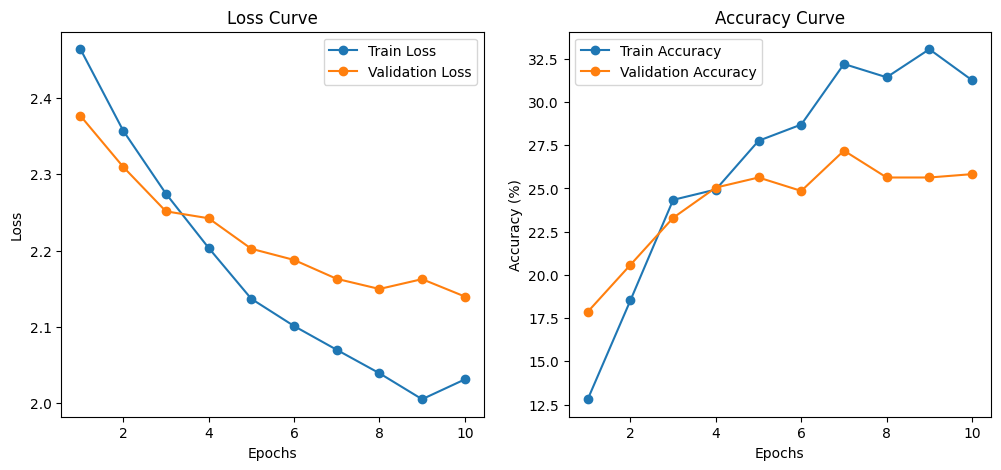

In [ ]:
# TO DO
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()


# BONUS Task: K-Fold Cross-Validation

Implement 5-fold cross-validation on the training dataset and print the accuracy scores for each fold by applying these steps:
- Use the `glob` module to collect image file paths from your training dataset.
- Create a pandas DataFrame that contains the file paths and corresponding labels.
- Implement `KFold` loop to split the DataFrame into training and validation folds.
- Inside the KFold loop, initialize your train and validation dataloaders, model and run the training.



In [ ]:
from sklearn.model_selection import KFold

# TO DO